Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph

categories:[multimodal learning, deep learning, Transformer, Graph]

Motivation
In the article 'Multimodal Fustion Deep Learning for Drug Proerty Prediction: Integrating Chemical Language and Molecular Graph', the MMFDL model is used for predicting drug properties. We tested the model using six single-molecule datasets, including Delaney, Llinas2020, Lipophilicity, SAMPL, BACE and pKa from DataWarrior. 
In this post, we use the SAMPL dataset for how to train MMFDL model. The input of the model is to convert drug molecules into three molecular representations: SMILES-encoed vectors、ECFP fingerprints and molecular graphs. To process the modal nformation, Transformer-Ecoder、BiGRU and graph convolutional network(GCN) are utilized for feature learning respectively. Then this model uses five fusion methods to capture specific features.

I'll use SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset fro protein and ligand modeling and consists of 642 experimental values logP.

Let's take the SAMPL dataset as an example. The SAMPL dataset from MoleculeNet is a statistical evaluation dataset for protein and ligand modeling and consists of 642 experimental values logP.

MMFDL_singleTrans.ipynb is a single Transformer-Encoder model.

Prepare training data and testing data.

In [2]:
# from myTrCPI.script.makeModel.utils_smiecfp import *
from sklearn import metrics
# from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import InMemoryDataset, DataLoader
# from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import warnings
import pickle
import sys
sys.path.append('../util')
from utils_smiecfp import *
from data_gen_modify import *
from analysis import *
from utils import *

sys.path.append('../model')
from model_trans_bigru_gcn import modelTransformer_smi


gpu_index = 0  # 可以根据需要更改为其他 GPU 编号

# 检查是否有可用的 GPU 设备
if torch.cuda.is_available():
    # 设置为指定的 GPU 设备
    device = torch.device(f'cuda:{gpu_index}')
else:
    # 如果没有可用的 GPU，使用 CPU
    device = torch.device('cpu')


epochs = 50
batch_size = 16
label = 0
random_state=42

argsLstm = {
    'num_features': 44,
    'max_features': 44, 
    'dropout': 0.1, 
    'num_layer': 2,
    'num_heads': 2,
    'hidden_dim': 256,
    'output_dim': 128,
    'n_output': 1,
}


resultLoss = {'losses_train': [], 'losses_val': []}

train_data = formDataset(root='../dataSour', dataset='data_train')
train_ratio = 0.8
num_data = len(train_data)
indices = list(range(num_data))
train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True, random_state=random_state)
train_dataset = [train_data[i] for i in train_indices]
val_dataset = [train_data[i] for i in val_indices]
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_data = formDataset(root='../dataSour', dataset='data_test')
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Pre-processed data found: ../dataSour/processed/data_train.pt, loading ...
Pre-processed data found: ../dataSour/processed/data_test.pt, loading ...


/home/bioinfor3/.conda/envs/lxh-TransFM3/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


The input to Transformer-Encoder is SMILES-encoded vectors.

In [3]:
learning_rate = 0.0001
model = modelTransformer_smi(argsLstm).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

model.train()
for i in range(epochs):
    print("Running EPOCH",i+1)
    total_loss = 0
    n_batches = 0
    correct = 0
    '''
        train部分
    '''
    for batch_idx, data in enumerate(trainLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        y = torch.FloatTensor(data.y).to(device)
        y_pred = model(encodedSmi, encodedSmi_mask) 
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_train'].append(avg_loss)
    print('train avg_loss is: ', avg_loss.item())

    '''
        val部分
    '''
    total_loss = 0
    n_batches = 0
    correct = 0
    for batch_idx, data in enumerate(valLoader):
        encodedSmi = torch.LongTensor(data.smi).to(device)
        encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
        y = torch.FloatTensor(data.y).to(device)
        y_pred = model(encodedSmi, encodedSmi_mask) 
        loss = criterion(y_pred.type(torch.DoubleTensor).squeeze(), y.type(torch.DoubleTensor))
        total_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        n_batches+=1
    avg_loss = total_loss / n_batches
    resultLoss['losses_val'].append(avg_loss) 
    print('val avg_loss is: ', avg_loss.item())
    print('\n')



y_pred_list = []
y_sour_list = []
correct = 0
model.eval()
for batch_idx, data in enumerate(testLoader):
    encodedSmi = torch.LongTensor(data.smi).to(device)
    encodedSmi_mask = torch.LongTensor(getInput_mask(data.smi)).to(device)
    y = torch.FloatTensor(data.y).to(device)
    y_pred = model(encodedSmi,encodedSmi_mask)
    y_pred_list.append(y_pred.squeeze().tolist())
    y_sour_list.append(y.tolist())

y_pred = []
for data in y_pred_list:
    for item in data:
        value = round(item, 2)
        y_pred.append(value)

y = []
for data in y_sour_list:
    for item in data:
        value = round(item, 2)
        y.append(value)

yResult = {}
ground_truth = np.array(y)
predictions = np.array(y_pred)
# calculate rmse
squared_errors = (ground_truth - predictions) ** 2
rmse = np.sqrt(np.mean(squared_errors))
yResult['rmse'] = rmse
# calculate mae
absolute_errors = np.abs(ground_truth - predictions)
mae = np.mean(absolute_errors)
yResult['mae'] = mae
print(yResult)


Running EPOCH 1
train avg_loss is:  19.720295804255407
val avg_loss is:  10.120392570131637


Running EPOCH 2
train avg_loss is:  12.28200829967662
val avg_loss is:  7.247201275695284


Running EPOCH 3
train avg_loss is:  8.857063687187274
val avg_loss is:  5.573549530749983


Running EPOCH 4
train avg_loss is:  7.307916920663571
val avg_loss is:  4.594930694481207


Running EPOCH 5
train avg_loss is:  5.996913734732506
val avg_loss is:  3.66475107138675


Running EPOCH 6
train avg_loss is:  5.464875666112797
val avg_loss is:  3.3268408539254373


Running EPOCH 7
train avg_loss is:  4.915902957684862
val avg_loss is:  3.5073597531326457


Running EPOCH 8
train avg_loss is:  4.359946767494092
val avg_loss is:  2.791551088379638


Running EPOCH 9
train avg_loss is:  4.267097426147687
val avg_loss is:  3.0493741204558185


Running EPOCH 10
train avg_loss is:  3.911369079243564
val avg_loss is:  2.600982052089336


Running EPOCH 11
train avg_loss is:  3.5836946362690454
val avg_loss is:  2

Save results

pearson:  (0.9123322177952049, 2.8240060080773907e-36)
0.9473782514471946 0.9123322177952052


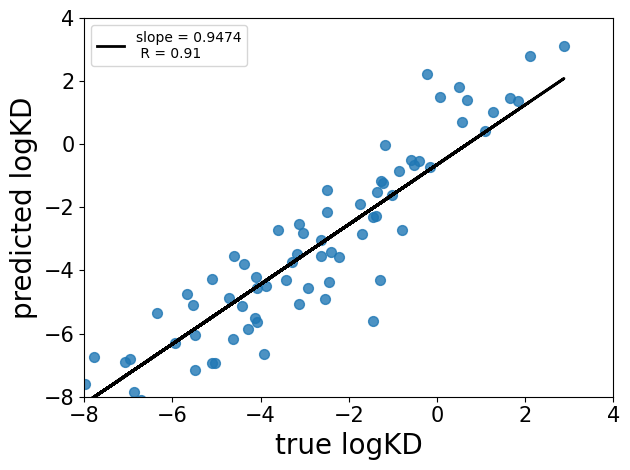



../result/0-result-16-50-42-transformer(smi).csv	saved successfully


: 

In [4]:
savePath = '../result/{}_rmseMae_{}_{}_{}_transformer(smi).csv'.format(label, batch_size, epochs, random_state)
rmseAndMae(yResult, savePath)


savePath = '../result/{}_scatter_predited_{}_{}_{}_transformer(smi).png'.format(label, batch_size, epochs, random_state)
pltPredict_linregress(y_pred, y, savePath)
print('\n')

result = {}
result['y_pred'] = y_pred
result['y'] = y
resultPath = '../result/{}-result-{}-{}-{}-transformer(smi).csv'.format(label, batch_size, epochs, random_state)
resultDf = pd.DataFrame(result)
resultDf.to_csv(resultPath, index=False)
print(resultPath + '\tsaved successfully')

savePath = '../result/{}_loss_{}_{}_{}_transformer(smi).png'.format(label, batch_size, epochs, random_state)

savePath = '../result/{}_loss_{}_{}_{}_transformer(smi).csv'.format(label, batch_size, epochs, random_state)
lossDf = pd.DataFrame(resultLoss)
lossDf.to_csv(savePath, index=False)